In [1]:
import pandas as pd
import numpy as np

# Read all data and set hn as index

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Data Preprocessing

Check number of data

In [3]:
df.shape

(1723, 23)

Check any missing data in each column

In [4]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

Delete column with missing data

In [5]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean_column.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
stage          24
pchemo          1
finalhisto     10
size          114
utmet          98
vgmet          97
pmmet          94
dtype: int64

Delete row with at least 1 missing data

In [6]:
df_clean = df_clean_column.dropna(axis = 0)

Total Clean Data

In [7]:
df_clean.shape

(1555, 15)

Check number of sample in pelvicme class 

In [8]:
pel_class = np.unique(df_clean['pmmet'])
pel_class

array([0., 1.])

In [9]:
pel_value = [sum(df_clean['pmmet']==pel_class[0]),
             sum(df_clean['pmmet']==pel_class[1])]
pel_value

[1278, 277]

Separate pelviceme dataset into data (X) and label (y)

In [10]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

Separate Data into Train & Test (Note: Imbalance Dataset)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

Data normalization to range of (0 to 1)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Logistic Regression 

10-Folds Cross Validation Training Accuracy with Tuning

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 4, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 1}
10CV accuracy : 83.36193548387098


Test Accuracy

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 84.56591639871382


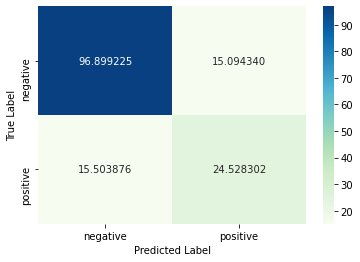

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

The precision is the ratio tp / (tp + fp). The precision is the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn). The recall is the ability of the classifier to find all the positive samples.

The F score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The support is the number of occurrences of each class in y_true.

In [19]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.86      0.97      0.91       258
    positive       0.62      0.25      0.35        53

    accuracy                           0.85       311
   macro avg       0.74      0.61      0.63       311
weighted avg       0.82      0.85      0.82       311



# Support Vector Machine

10-Folds Cross Validation Training Accuracy

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [1,2,4,8,16,32], # High C = Overfitting
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 8, 'gamma': 0.5}
10CV accuracy : 84.2458064516129


Test Accuracy

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.8167202572347267

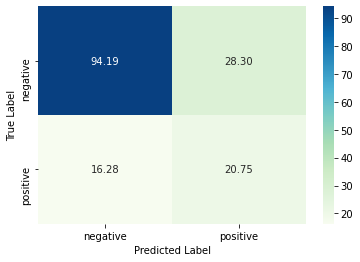

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [23]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.94      0.90       258
    positive       0.42      0.21      0.28        53

    accuracy                           0.82       311
   macro avg       0.64      0.57      0.59       311
weighted avg       0.78      0.82      0.79       311



# Random Forest

10-Folds Cross Validation Training Accuracy

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100,200,500],
    'min_samples_leaf' : [1,2,4,8,16,32],
    'max_features' : ['sqrt',0.5,0.8],
    'criterion' : ['gini','entropy']
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'criterion': 'entropy', 'max_features': 0.8, 'min_samples_leaf': 4, 'n_estimators': 100}
10CV accuracy : 84.64903225806452


Test Accuracy

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.8135048231511254

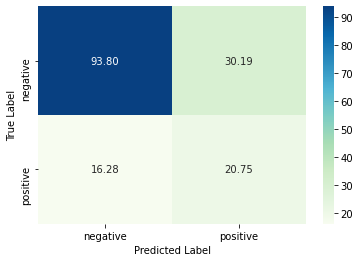

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [29]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.94      0.89       258
    positive       0.41      0.21      0.28        53

    accuracy                           0.81       311
   macro avg       0.63      0.57      0.58       311
weighted avg       0.78      0.81      0.79       311



# XGBoost

10-Folds Cross Validation Training Accuracy

In [31]:
#!pip install xgboost  // If you dont have XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100,200],
    'max_depth' : [2, 4, 8],
    'learning_rate' : [0.001, 0.01, 0.1],
    'subsample' : [0.5,0.8, 1],
    'colsample_bytree' : [0.5, 0.8, 1]    
}
clf = GridSearchCV(xgb.XGBClassifier(random_state=0, objective='binary:logistic',n_jobs=-1),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'subsample': 0.5}
10CV accuracy : 84.4883870967742


Test Accuracy

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.8231511254019293

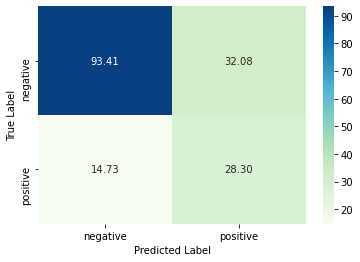

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [34]:
print(classification_report(y_test, y_predict, target_names=target_names))

NameError: name 'y_predict1' is not defined